# **ML for XAS Tutorial**

### CECAM · ALC · CCP9 Spectroscopy Masterclass  

**Haili Jia (hjia@anl.gov)**  

*Argonne National Laboratory*  



### Packages needed

**Required**
- `numpy`
- `matplotlib`
- `scikit-learn`
- `scipy`
- `xgboost` *(on macOS also install `libomp`; with conda: `conda install -c conda-forge libomp xgboost`)*
- `torch` (PyTorch)
- `pymatgen`

**Optional (for code in the markdown cells)**
- `optuna` or `scikit-optimize` *(Bayesian HPO)*
- `shap` *(feature attributions for tree models)*

**Example installs**

**Conda**
```bash
conda install -c conda-forge numpy matplotlib scipy scikit-learn ipython pymatgen pytorch xgboost libomp
```
**Pip**
```bash
pip install numpy matplotlib scipy scikit-learn ipython pymatgen xgboost torch
# macOS note: if you see libomp errors:
#   brew install libomp
# or use the conda-forge xgboost above.

In [1]:
! pip install numpy matplotlib scipy scikit-learn ipython pymatgen xgboost torch


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown

# SciPy
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

# scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Pymatgen
from pymatgen.core import Structure

# XGBoost
from xgboost import XGBRegressor

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# 1. XAS database

In [3]:
database_table = """
| Database | Type | Description |
|---|---|---|
| [Materials Project XAS (U.S.)](https://next-gen.materialsproject.org/xas) | Simulated | >500,000 K-edge and ~140,000 L2,3-edge spectra (FEFF9) across tens of thousands of materials. | 
| [Li thiophosphate S K-edge (Materials Cloud, U.S.)](https://archive.materialscloud.org/records/g5aby-h6029) | Simulated | 2,681 simulated sulfur K-edge spectra for Li–P–S electrolytes (18 crystalline + 48 amorphous structures). | 
| [IXAS](https://xaslib.xrayabsorption.org/) | Experimental | ~277 XANES/EXAFS spectra across ~20 elements; interactive periodic table. | 
| [CLS XAS Database (CLS, Canada))](https://xasdb.lightsource.ca/) | Experimental | XANES/EXAFS from Canadian Light Source with periodic-table search & downloads. | 
| [SSHADE / FAME (Fame, France)](https://www.sshade.eu/db/fame) | Experimental | ~735 XANES/EXAFS spectra from ESRF beamlines, collected across 429 samples; DOIs included. Need registration for downloading.| 
| [SPring-8 BL14B2 Standard DB (JASRI, Japan)](https://support.spring8.or.jp/BL/bl14b2/xafs/standardDB/index-e.html) | Experimental | ~2000 spectra across 858 samples anb 43 elements with metadata. Registration needed.| 
| [MDR XAFS DB (NIMS, Japan)](https://mdr.nims.go.jp/collections/qz20st57x) | Experimental | ~2,264 spectra with unified metadata; API access. | 
| [XASDB (IHEP, China)](https://xasdb.ihep.ac.cn/) | Experimental | ~150 spectra (metals, oxides, minerals), interactive periodic table. |
| [RefXAS (Germany)](http://xafsdb.ddns.net) | Experimental | Curated XANES/EXAFS reference datasets for functional materials; contains metadata. |
| [EELSdb (includes XAS)](https://eelsdb.eu/) | Hybrid (EELS + XAS) | Community-driven database of EELS and XAS spectra; interactive & API; contains metadata. | 
"""

In [4]:
Markdown(database_table)


| Database | Type | Description |
|---|---|---|
| [Materials Project XAS (U.S.)](https://next-gen.materialsproject.org/xas) | Simulated | >500,000 K-edge and ~140,000 L2,3-edge spectra (FEFF9) across tens of thousands of materials. | 
| [Li thiophosphate S K-edge (Materials Cloud, U.S.)](https://archive.materialscloud.org/records/g5aby-h6029) | Simulated | 2,681 simulated sulfur K-edge spectra for Li–P–S electrolytes (18 crystalline + 48 amorphous structures). | 
| [IXAS](https://xaslib.xrayabsorption.org/) | Experimental | ~277 XANES/EXAFS spectra across ~20 elements; interactive periodic table. | 
| [CLS XAS Database (CLS, Canada))](https://xasdb.lightsource.ca/) | Experimental | XANES/EXAFS from Canadian Light Source with periodic-table search & downloads. | 
| [SSHADE / FAME (Fame, France)](https://www.sshade.eu/db/fame) | Experimental | ~735 XANES/EXAFS spectra from ESRF beamlines, collected across 429 samples; DOIs included. Need registration for downloading.| 
| [SPring-8 BL14B2 Standard DB (JASRI, Japan)](https://support.spring8.or.jp/BL/bl14b2/xafs/standardDB/index-e.html) | Experimental | ~2000 spectra across 858 samples anb 43 elements with metadata. Registration needed.| 
| [MDR XAFS DB (NIMS, Japan)](https://mdr.nims.go.jp/collections/qz20st57x) | Experimental | ~2,264 spectra with unified metadata; API access. | 
| [XASDB (IHEP, China)](https://xasdb.ihep.ac.cn/) | Experimental | ~150 spectra (metals, oxides, minerals), interactive periodic table. |
| [RefXAS (Germany)](http://xafsdb.ddns.net) | Experimental | Curated XANES/EXAFS reference datasets for functional materials; contains metadata. |
| [EELSdb (includes XAS)](https://eelsdb.eu/) | Hybrid (EELS + XAS) | Community-driven database of EELS and XAS spectra; interactive & API; contains metadata. | 


# 2. Metrics

## 2.1 Data used in this tutorial
**Contains:** Both experimental and simulated XAS of NMC Ni K-edge

**Cication:** Chen, Y., Chen, C., Hwang, I., Davis, M. J., Yang, W., Sun, C., Lee, G.-H., McReynolds, D., Allen, D., Arias, J. M., Ong, S. P., & Chan, M. K. Y. (2024). Robust Machine Learning Inference from X-ray Absorption Near Edge Spectra through Featurization. https://doi.org/10.5281/zenodo.10535353

In [15]:
xas_exp  = "nmc_exp_xas.json"
xas_vasp = "nmc_vasp_xas.json"

In [6]:
with open(xas_exp, "r") as f_exp:
    data = json.load(f_exp)
    e_exp = np.arange(8330, 8370, 0.4)
    i_exp = np.array(data["intensity"]['0'])
    print("Data length:", len(i_exp))
    print("Data label:", "volatge:", data["voltage"]['0'], "composition:", data["composition"]['0'])

Data length: 100
Data label: volatge: N/A composition: NMC622


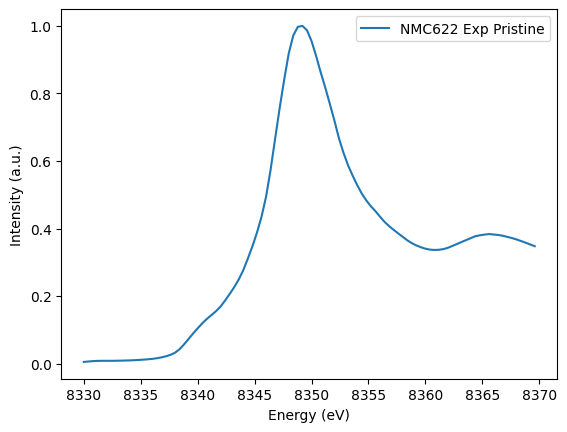

In [16]:
plt.plot(e_exp, i_exp, label="NMC622 Exp Pristine")
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()

In [17]:
with open(xas_vasp, "r") as f_comp:
    data = json.load(f_comp)
    e_comp = np.array(data["energy"]['438'])
    i_comp = np.array(data["intensity"]['438'])
    print("Composition:", Structure.from_dict(data["structure"]['438']).composition)
    print("Data length:", len(i_comp))

Composition: Li10 Mn2 Co2 Ni6 O20
Data length: 100


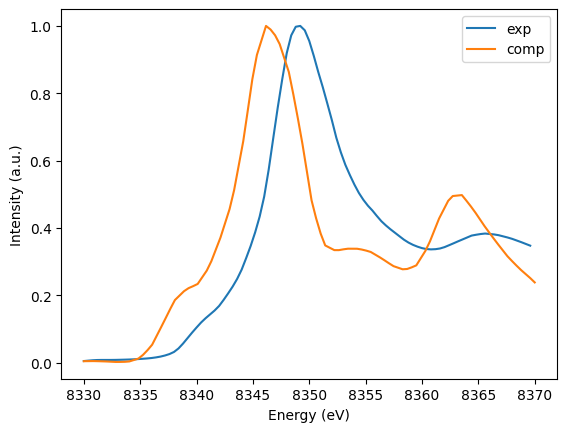

In [9]:
plt.plot(e_exp, i_exp, label='exp') 
plt.plot(e_comp, i_comp, label='comp')
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()

[8330.         8330.4040404  8330.80808081 8331.21212121 8331.61616162
 8332.02020202 8332.42424242 8332.82828283 8333.23232323 8333.63636364] [0.00470278 0.00486919 0.0050356  0.00474345 0.00431703 0.00383497
 0.00318429 0.00253361 0.00258335 0.00290179]
[8333.2 8333.6 8334.  8334.4 8334.8 8335.2 8335.6 8336.  8336.4 8336.8] [0.00478516 0.0049499  0.00489683 0.00454517 0.00409769 0.00354541
 0.00290124 0.00255475 0.00271551 0.00334796]


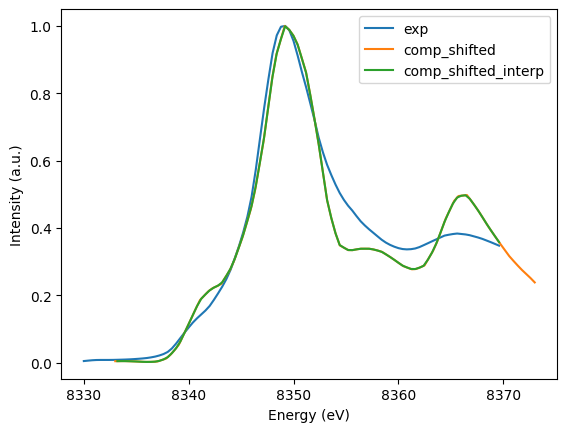

In [18]:
shift_ev = 3.0
e_comp_shift = e_comp + shift_ev

# find overlap of (shifted comp) with exp range
emin, emax = e_exp.min(), e_exp.max()
overlap_mask_exp = (e_exp >= e_comp_shift.min()) & (e_exp <= e_comp_shift.max())
e_exp_overlap = e_exp[overlap_mask_exp]
i_exp_overlap = i_exp[overlap_mask_exp]

# map comp intensity onto the exp grid (in the overlap)
print(e_comp[:10],i_comp[:10])
i_comp_on_exp = np.interp(e_exp_overlap, e_comp_shift, i_comp)
print(e_exp_overlap[:10],i_comp_on_exp[:10])

plt.plot(e_exp, i_exp, label='exp')
plt.plot(e_comp_shift, i_comp, label='comp_shifted')
plt.plot(e_exp_overlap, i_comp_on_exp, label='comp_shifted_interp')
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()

92


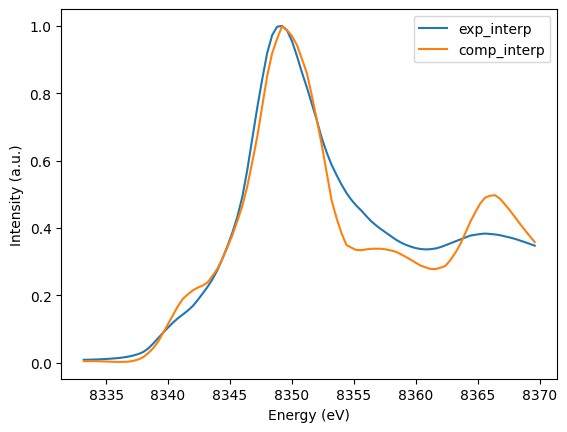

In [11]:
print(len(e_exp_overlap))
plt.plot(e_exp_overlap, i_exp_overlap, label='exp_interp')
plt.plot(e_exp_overlap, i_comp_on_exp, label='comp_interp')
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()

## 2.2 Spectrum similarity metrics

Compare two spectra sampled on the **same energy grid**:
- Two spectra have equal length and energy interval.
- Remove or interpolate any NaNs before computing metrics.

Below are formulas + brief usage for **Pearson**, **Spearman**, and **Cosine** similarity.


### 2.2.1 Pearson correlation

**What it measures:** Linear correlation in amplitude and shape (sensitive to scaling and offsets).

**Formula** (with sample means $\bar{x}, \bar{y}$):
$$r_{xy} \;=\; \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2}\;\sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}$$

**Range:** [-1, 1] (r value: 1 = perfect linear relation, 0 = none, −1 = inverse linear, p value <0.05: statistically significant)


In [19]:
# Before shifting
r_pearson, p_pearson = pearsonr(i_exp, i_comp)
print("Before shifting: Pearson r =", r_pearson, "| p =", p_pearson)

# After shifting
r_pearson, p_pearson = pearsonr(i_exp_overlap, i_comp_on_exp)
print("After shifting: Pearson r =", r_pearson, "| p =", p_pearson)

Before shifting: Pearson r = 0.6649725583727087 | p = 4.518371187198015e-14
After shifting: Pearson r = 0.976010700113934 | p = 2.2142784255741128e-61


### 2.2.2 Spearman rank correlation

**What it measures:** Monotonic similarity between two vectors (agreement in ordering). Robust to any monotonic rescaling; sensitive to misalignment along the axis (e.g., energy shifts).

**Definition:** Let \(R(x_i)\) and \(R(y_i)\) be the ranks of \(x_i, y_i\). Spearman is the **Pearson correlation of ranks**:
$$\rho \;=\; \frac{\sum_{i=1}^{n} \big(R(x_i)-\overline{R_x}\big)\big(R(y_i)-\overline{R_y}\big)}{\sqrt{\sum_{i=1}^{n} \big(R(x_i)-\overline{R_x}\big)^2}\;\sqrt{\sum_{i=1}^{n} \big(R(y_i)-\overline{R_y}\big)^2}}$$


**Range:** [-1, 1] (1 = perfect monotonic increase (perfect alignment), 0 = no association, −1 = inverse alignment)


In [13]:
rho, pval = spearmanr(i_exp, i_comp, nan_policy="omit")
print("Before shifting: Spearman ρ =", rho, "| p-value =", pval)

rho, pval = spearmanr(i_exp_overlap, i_comp_on_exp, nan_policy="omit")
print("After shifting: Spearman ρ =", rho, "| p-value =", pval)

Before shifting: Spearman ρ = 0.6945694569456946 | p-value = 1.1055553092712852e-15
After shifting: Spearman ρ = 0.940246289474901 | p-value = 6.91404529053659e-44


### 2.2.3 Cosine similarity

**What it measures:** Angle between vectors (shape similarity, scale-invariant).
$$\text{cosine}(x,y) \;=\; \frac{\sum_{i=1}^{n} x_i y_i}{\sqrt{\sum_{i=1}^{n} x_i^2}\;\sqrt{\sum_{i=1}^{n} y_i^2}}$$

**Range:** [0, 1] for non-negative data (+1 = same direction/identical shape, 0 = orthogonal, -1 = opposite direction).


In [14]:
cos_sim_before = cosine_similarity(i_exp.reshape(1, -1), i_comp.reshape(1, -1))[0, 0]
cos_sim_after = cosine_similarity(i_exp_overlap.reshape(1, -1), i_comp_on_exp.reshape(1, -1))[0, 0]

print("Before shifting: Cosine similarity =", cos_sim_before)
print("After shifting: Cosine similarity =", cos_sim_after)

Before shifting: Cosine similarity = 0.8798016469874749
After shifting: Cosine similarity = 0.9919749517827596


### 2.3 Practical notes
- **Match energy grids first** (same `E` points for both spectra). Interpolate one to the other before computing metrics.
- **Mask NaNs** Remove `nan`.
- **Scaling:** Pearson is sensitive to linear scaling/offset; Cosine ignores overall magnitude; Spearman ignores monotonic nonlinear distortions.
- For XAS, you may compute metrics within **windows** (e.g., pre-edge, white line, post-edge) to localize similarity.


# 3. XAS Simulation

## 3.1 Common XAS Simulation Codes
### 3.1.1 FDMNES
- **Website:** http://fdmnes.neel.cnrs.fr/
- **Method:** Real-space multiple scattering + finite-difference (PAW/relativistic options).
- **Good for (elements & edges):**
  - **K edges** across the periodic table.
  - **L2,3 edges of heavy elements** (from second half of 3d) where band-like picture works well;
- **Note:** For L2,3 edges of the first half of 3d elements, need turn on TDDFT.

---

### 3.1.2 FEFF
- **Website:** https://feff.phys.washington.edu
- **Method:** Real-space Green’s-function multiple scattering;
- **Good for (elements & edges):**
  - **XANES** at many **K** edges (Si–Cu, etc.) and **L** edges of heavier elements.
  - **EXAFS** at **K/L/M** edges for virtually all elements.

---

### 3.1.3 VASP (core-hole supercell / core-level BSE)
- **Website:** https://www.vasp.at/
- **Method:** Plane-wave DFT (PAW) with explicit core-hole (`ICORELEVEL`) and tags like `CH_LSPEC`; newer versions add **core-level BSE** for improved near-edge features.
- **Good for (elements & edges):**
  - **K edges of light elements** (C/N/O/F, Si, P, S…) — chemistry-sensitive XANES with core-hole supercells.
  - **Some heavy-element L edges** (e.g., LIII of 4d/5d) when multiplet effects are moderate, especially with core-BSE.
  - **Not recommended for 3d-metal L2,3** (Ti–Cu) unless you accept missing multiplet physics; consider multiplet/BSE codes instead.

---

### 3.1.4 Other codes
- Quantum Espresso (XSpectra): https://www.quantum-espresso.org/Doc/INPUT_XSPECTRA API: https://aiidalab-qe.readthedocs.io/howto/xas.html
- Ocean: https://www.nist.gov/services-resources/software/ocean
- WIEN2k: http://susi.theochem.tuwien.ac.at
- AI2NBSE: https://feff.phys.washington.edu/feffproject-ai2nbse.html
- Exciting: https://exciting-code.org
- MSSpec: https://msspec.cnrs.fr/index.html


### 3.1.5 Practical tip for 3d L2,3 edges
Use **multiplet-capable** approaches (e.g., Quanty https://www.quanty.org/start, BSE, TDDFT frameworks designed for shallow-core) to capture 2p–3d multiplets and SOC splitting; plain DFT core-hole often fails here. 


## 3.2 FDMNES 

### 3.2.1 Sample input file

```text
Filout
  ./Fe2O3_out                 ! Base name of output files (no extension)

Range
  -1.0  0.1  8.0  0.5  30     ! Energy range relative to Ef: near-edge start, fine step, end, coarse step, (last arg per your setup)

SCF                           ! Self-consistent potentials before XAS

Radius
  5.0                         ! Cluster radius [Å]. (For XANES, consider 5–8 Å if feasible.)

Edge
  L23                           ! 2p -> 3d edges (L2+L3). 

Green                         ! Multiple scattering (Green's function) with muffin-tin potential 

! Optional but useful for L-edges:
! TDDFT                       ! Include TDDFT
! Relativistic                ! Enable relativistic treatment / SOC if needed for L-edges (check your build/keyword)
! Quadrupole                  ! Include E2 (useful for some L-edge pre-edge features)
 
Crystal                       ! Finite cluster (no periodicity). Symmetry inferred automatically.
  5.4135   5.4135   5.4135    55.283 55.283 55.283   = a, b, c, alpha, beta, gamma
 26  0.105    0.105    0.105       Fe
 26  0.395    0.395    0.395       Fe
 26  0.605    0.605    0.605       Fe
 26  0.895    0.895    0.895       Fe
  8  0.292    0.708    0.000       O 
  8  0.708    0.000    0.292       O 
  8  0.000    0.292    0.708       O 
  8  0.208    0.792    0.500       O 
  8  0.792    0.500    0.208       O 
  8  0.500    0.208    0.792       O 

Z_Absorber                  
 26                           ! Fe K-edge
 
Convolution                   ! Post-processing broadening block
!  CoreHole    0.9            ! Example: energy-dependent Lorentzian (eV). Set per edge/material.
!  Instrument  0.6            ! Example: Gaussian FWHM (eV) for beamline/monochromator resolution.

End



## 3.2.2 Tips for Fdmnes
If you are not satisfied with the calculation results from the default settings, try the following:
- Increase `radius`: Adjust the value up to convergence.
- Turn on `SCFexc`: By default, in FDMNES, self-consistency is performed without a core-hole at the K, L1, M1, and O1 edges, with the core-hole and its screening charge added only during the XANES step. When the agreement is not sufficiently good, particularly at the rising edge, this behavior can be modified using `SCFexc` (which includes the core-hole during the SCF step).
- Improve convolution: Experiment with `Gamma_max` and/or `Gamma_hole`. Refer to the documentation for more details.
- If you encounter memory issues, try turning off `Spinorbit`, downgrading to `Relativism`, or switching to a non-relativistic calculation by enabling `Nonrelat`.
- If you just want to perform a quick calculation, use the multiple scattering theory by turning on `Green`.

## 3.3 Generating simulation input with Lightshow

- **Lightshow repo:** https://github.com/AI-multimodal/Lightshow  
- **What it does (relevant here):** Helps template XAS inputs (FDMNES/FEFF/VASP/OCEAN/Exciting/XSpectra) directly from structures (ASE/pymatgen), with explicit absorber selection, edge, cluster radius, and energy windows.
- **Typical workflow:**  
  1) Load a structure (CIF/POSCAR) via ASE or pymatgen, or via material ID in Materials Projects.
  2) Pick the **absorber atom index** and **edge** (e.g., `L23`).
  3) Modify **calculation settings** on top of the default card.  
  4) Export the **Input file** and run.


# 4. Machine Learning for XAS

## 4.1 Generating training data

### 4.1.1 Goals
- **Inverse** (Spectrum → property/structure)
- **Forward** (Structure → spectrum)
- **Denoising**

### 4.1.2 Data sources
- **Database** (See 1. XAS Database)
- **Simulated XAS**
  - Benchmarking (pick a few reference compounds with high-quality experimental spectra, evaluate with metrics (See 2. Metrics))
  - Automated pipeline (template inputs, manage metadata, etc.)
- **Group splits** by composition/prototype to **avoid leakage**

## 4.2 Basic principles

### 4.2.1 Representations and features
- Start from **normalized**, aligned intensity on a **fixed** grid.
- **Baseline feature**: raw intensity vector

In [20]:
print(i_comp)

[0.00470278 0.00486919 0.0050356  0.00474345 0.00431703 0.00383497
 0.00318429 0.00253361 0.00258335 0.00290179 0.00400343 0.00829043
 0.01257742 0.02349958 0.03766087 0.05361937 0.08004187 0.10646438
 0.13332633 0.16045626 0.18624593 0.19938652 0.2125271  0.22155353
 0.22748162 0.23403818 0.25392197 0.27380577 0.30156156 0.33659407
 0.37162659 0.41389182 0.45619879 0.51264365 0.58510337 0.65756309
 0.74911932 0.84181933 0.91378461 0.9568923  1.         0.98929316
 0.97211917 0.94608878 0.90480471 0.86352064 0.7966982  0.72508157
 0.64965886 0.566019   0.48237913 0.42897879 0.38356001 0.34836075
 0.34139187 0.33442299 0.33439119 0.33679164 0.33866093 0.33859101
 0.33852108 0.33623967 0.33296297 0.32891328 0.32093025 0.31294721
 0.30432296 0.29533623 0.28684127 0.28218829 0.27753531 0.27847396
 0.28332916 0.28923135 0.31078506 0.33233878 0.36052957 0.39443562
 0.42825057 0.45451955 0.48078853 0.49497111 0.49639865 0.4978262
 0.48117688 0.463797   0.44527007 0.42525794 0.40524582 0.38685

- **CDF**: cumulative integral of intensity over energy

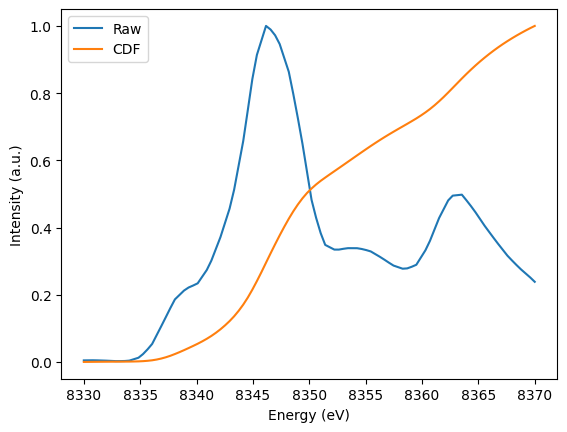

In [21]:
i_comp_cdf = np.cumsum(i_comp)
i_comp_cdf_norm = np.cumsum(i_comp)/i_comp_cdf[-1]

plt.plot(e_comp, i_comp, label = 'Raw')
plt.plot(e_comp, i_comp_cdf_norm, label = 'CDF')

plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()

- **Polynomial descriptors** (Torrisi et al):
  - Divide the analysis window into N equal regions at different scales: 2.5 eV, 5 eV.
  - In each region, fit a cubic polynomial `a0 + a1 E + a2 E^2 + a3 E^3`; collect the four coefficients `a0, a1, a2, a3`.
  - Concatenate coefficients across all regions and scales.

In [22]:
def _region_masks(E, edges, i):
    """Half-open regions except the last which is closed at the right end."""
    if i < len(edges) - 2:
        return (E >= edges[i]) & (E < edges[i+1])
    else:
        return (E >= edges[i]) & (E <= edges[i+1])

def piecewise_cubic_fit(mu, E, region_size_eV=5.0):
    """
    Fit a cubic in each equal-width region across [E.min(), E.max()].
    Returns yhat (same shape as mu), coeffs (list of [a0,a1,a2,a3] per region), edges.
    """
    E0, E1 = float(E[0]), float(E[-1])
    n_regions = max(1, int(np.floor((E1 - E0) / region_size_eV)))
    edges = np.linspace(E0, E1, n_regions + 1)

    yhat = np.zeros_like(mu, dtype=float)
    coeffs = []
    for i in range(n_regions):
        m = _region_masks(E, edges, i)
        x = E[m]
        y = mu[m]
        if x.size < 4:
            # Fallback: constant fit if too few points
            c = np.array([y.mean() if y.size else 0.0, 0.0, 0.0, 0.0])
        else:
            # Design matrix for cubic: [1, x, x^2, x^3]
            X = np.vstack([np.ones_like(x), x, x**2, x**3]).T
            c, *_ = np.linalg.lstsq(X, y, rcond=None)
        coeffs.append(c)
        yhat[m] = c[0] + c[1]*x + c[2]*x**2 + c[3]*x**3
    return yhat, np.array(coeffs), edges

def plot_piecewise_cubic_fit(E, mu, region_size_eV=5.0, show_knots=True, title=None):
    """
    Plot original spectrum and piecewise-cubic fit for a given region size.
    """
    yhat, coeffs, edges = piecewise_cubic_fit(mu, E, region_size_eV=region_size_eV)
    rmse = np.sqrt(np.mean((mu - yhat)**2))

    plt.figure()
    plt.plot(E, mu, label="spectrum")
    plt.plot(E, yhat, label=f"cubic fit ({region_size_eV} eV regions)")
    if show_knots:
        for e in edges:
            plt.axvline(e, linestyle="--", linewidth=0.8)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Intensity (a.u.)")
    if title is None:
        plt.title(f"cubic fit (RMSE={rmse:.4g})")
    else:
        plt.title(title + f" (RMSE={rmse:.4g})")
    plt.legend()
    plt.tight_layout()

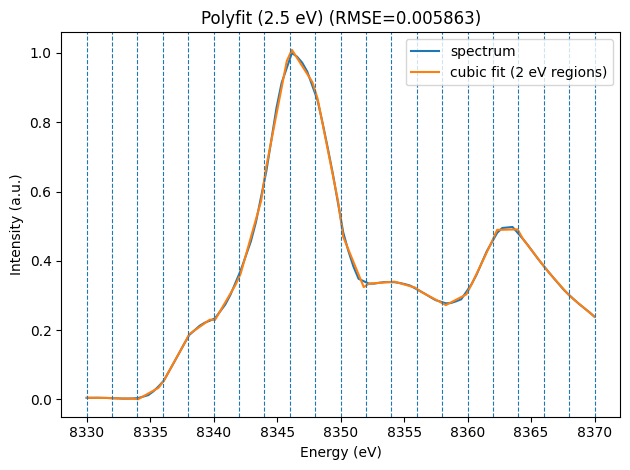

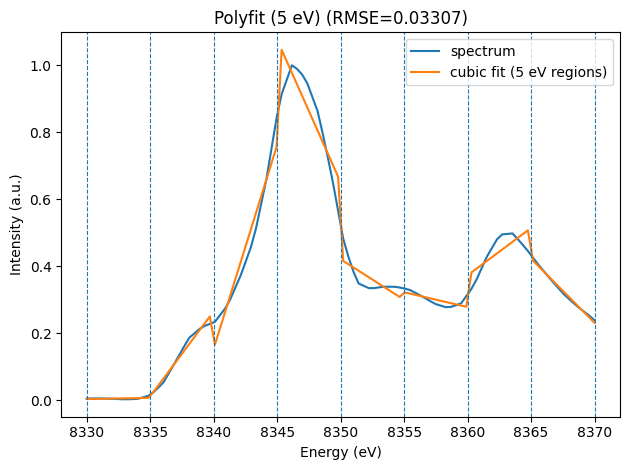

In [23]:
plot_piecewise_cubic_fit(e_comp, i_comp, region_size_eV=2, show_knots=True, title="Polyfit (2.5 eV)")
plot_piecewise_cubic_fit(e_comp, i_comp, region_size_eV=5, show_knots=True, title="Polyfit (5 eV)")

- **Gaussian peak decomposition**
  - Fit the spectrum with a sum of **20 Gaussians**; each peak has **center, amplitude, width**.
  - Constrain FWHM, amplitudes ≥ 0, etc.

In [24]:
def _sigma_from_fwhm(w):
    return np.clip(w, 1e-9, 5.0) / (2*np.sqrt(2*np.log(2)))

def gaussians_sum(E, params):
    """
    Sum of Gaussians with parameters [A1, x1, w1, A2, x2, w2, ...].
    w is FWHM in eV. Amplitudes are non-negative.
    """
    y = np.zeros_like(E, dtype=float)
    p = np.asarray(params).reshape(-1, 3)
    for A, xc, w in p:
        A = max(A, 0.0)
        sigma = _sigma_from_fwhm(w)
        y += A * np.exp(-0.5 * ((E - xc) / sigma)**2)
    return y

def fit_gaussian_mixture(E, mu, n_peaks=20, maxfev=20000):
    """
    Fit n_peaks Gaussians to spectrum mu(E) with bounds:
      amplitude >= 0, center in [E_min, E_max], FWHM in [0, 5] eV.
    Returns yhat, params (length 3*n_peaks), and a success flag.
    """
    centers0 = np.linspace(float(E[0]), float(E[-1]), n_peaks + 2)[1:-1]
    widths0 = np.full(n_peaks, 1.0)  # FWHM init (eV)
    amps0 = np.maximum(np.interp(centers0, E, mu), 0.0)

    p0 = np.ravel(np.column_stack([amps0, centers0, widths0]))

    lower = np.ravel(np.column_stack([np.zeros(n_peaks),
                                      np.full(n_peaks, float(E[0])),
                                      np.zeros(n_peaks)]))
    upper = np.ravel(np.column_stack([np.full(n_peaks, np.inf),
                                      np.full(n_peaks, float(E[-1])),
                                      np.full(n_peaks, 5.0)]))

    try:
        popt, _ = curve_fit(lambda x, *pp: gaussians_sum(x, pp),
                            E, mu, p0=p0, bounds=(lower, upper), maxfev=maxfev)
        yhat = gaussians_sum(E, popt)
        return yhat, popt, True
    except Exception:
        # Fallback to initial guess if fitting fails
        yhat = gaussians_sum(E, p0)
        return yhat, p0, False

def plot_gaussian_decomposition(E, mu, n_peaks=20, title=None):
    """
    Plot original spectrum, total Gaussian fit, and individual Gaussians.
    Creates its own figure (no subplots).
    """
    yhat, params, ok = fit_gaussian_mixture(E, mu, n_peaks=n_peaks)
    rmse = np.sqrt(np.mean((mu - yhat)**2))
    status = "fit" if ok else "init"

    plt.figure()
    plt.plot(E, mu, label="spectrum")
    plt.plot(E, yhat, label=f"{n_peaks}-Gaussian {status} (RMSE={rmse:.4g})")
    # draw individual peaks
    p = params.reshape(-1, 3)
    for A, xc, w in p:
        sigma = _sigma_from_fwhm(w)
        peak = np.maximum(A, 0.0) * np.exp(-0.5 * ((E - xc) / sigma)**2)
        plt.plot(E, peak, linestyle="--", linewidth=0.8, alpha=0.6)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized μ(E)")
    if title is None:
        plt.title(f"{n_peaks}-Gaussian decomposition")
    else:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    return params

[4.99018694e-03 8.33064042e+03 4.22844133e+00 1.49855315e-01
 8.33826281e+03 3.63702994e+00 1.04423166e-01 8.34011915e+03
 3.22897364e+00 1.73031739e-01 8.34167490e+03 2.47458551e+00
 3.07195620e-01 8.34316371e+03 2.24035566e+00 4.32175828e-01
 8.34439900e+03 1.73710627e+00 2.93714718e-01 8.34511583e+03
 1.18468859e+00 3.77620794e-01 8.34591838e+03 1.36337640e+00
 4.88462938e-01 8.34669803e+03 2.07460583e+00 6.03351760e-01
 8.34807633e+03 2.88404808e+00 3.04960763e-01 8.34987064e+03
 3.15014631e+00 2.10157042e-01 8.35237139e+03 3.15166575e+00
 1.86994507e-01 8.35433278e+03 3.18555088e+00 1.90611359e-01
 8.35625546e+03 3.32216563e+00 1.83029441e-01 8.35861557e+03
 3.47331473e+00 2.53361855e-01 8.36129242e+03 3.39736318e+00
 3.15572283e-01 8.36326984e+03 3.29472720e+00 2.18497839e-01
 8.36532198e+03 3.34041569e+00 1.46626087e-01 8.36721335e+03
 3.55095729e+00 2.10932894e-01 8.36999894e+03 4.99983112e+00]


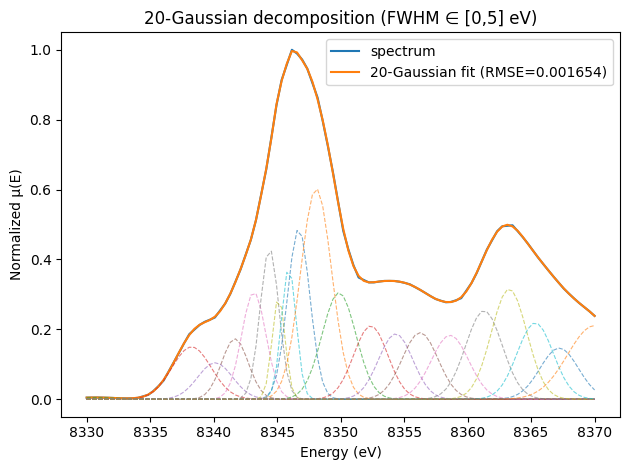

In [25]:
params = plot_gaussian_decomposition(e_comp, i_comp, n_peaks=20, title="20-Gaussian decomposition (FWHM ∈ [0,5] eV)")
print(params)

### 4.2.2 Dimensionality reduction

**Why: collinearity, noise suppression, sample efficiency, speed, visualization—plus XAS cautions (align & normalize first, fit only on train folds).** 

**SVD / PCA**  
- Treat spectra as rows of matrix **X** (shape: *n_samples × n_intensity*).  
- Low-rank model: $X \approx U_k S_k V_k^{\top}$; columns of $V_k$ are **eigenspectra**; scores $Z = X V_k$ are low-dim features.  
- Great first choice; components often resemble **baselines** + **derivative/white-line** modes.  
- Choose **k** via explained variance (e.g., **95–99%**) plus **downstream CV** performance.

**TruncatedSVD**  
- PCA-like but works **without centering** and scales well to **large/sparse** matrices.  
- Useful for gigantic energy grids or memory-constrained settings.

**NMF (Non-negative Matrix Factorization)**  
- Factorization: $X \approx W H$, with $W,H \ge 0$ → parts-based, interpretable “**archetype peaks/edges**”.  
- Natural for **non-negative spectra**; sensitive to scaling—use **edge-step normalization**.

**Manifold methods (for visualization)**  
- **t-SNE/UMAP**: non-linear 2-D/3-D embeddings to inspect clusters; **do not** feed directly into linear models (non-parametric mappings). 
- **Isomap / LLE / Diffusion maps**: capture global geometry; can reveal progression across **oxidation**/**coordination**.

**Autoencoders (AEs)**  
- Neural encoder/decoder learn a non-linear **bottleneck**; **Denoising AEs** help with noisy spectra.  
- Use with care on small datasets; **regularize** and **validate** rigorously.


### 4.2.3 A simple example

#### **Load data**

In [26]:
## Load training data (XAS) and label (Ni oxidation state)
with open(xas_vasp, "r") as f_comp:
    data = json.load(f_comp)
    keys = list(map(str, sorted(map(int, data["intensity"].keys()))))

    X = np.array([data["intensity"][k] for k in keys], dtype=float)
    y = np.array([data["oxidation_state"][k] for k in keys])

print(X.shape, y.shape)

(2831, 100) (2831,)


In [27]:
## Load experimental data
with open(xas_exp, "r") as f_exp:
    data = json.load(f_exp)
    keys = list(map(str, sorted(map(int, data["intensity"].keys()))))

    X_exp = np.array([data["intensity"][k] for k in keys], dtype=float)
    y_exp = np.array([data["voltage"][k] for k in keys])

print(len(X_exp), y_exp)

16 ['N/A' '4.3' '4.8' '3.0' '4.3' '4.8' '4.8' '3.0' 'N/A' '4.3' '4.8' '3.0'
 '4.3' '4.8' '4.8' '3.0']


#### **Example workflow 1: CDF with XGBoost**

**What it is**  
XGBoost is a fast, regularized **gradient-boosted decision tree** method: it builds many shallow trees sequentially, each correcting the last, with built-in L1/L2 regularization, subsampling, and early stopping.

**Why use in XAS (small dataset).**  
- Handles **nonlinear interactions** in tabular features (e.g., CDF, peak/shape descriptors) without needing huge datasets.  
- **Scale-invariant** splits (trees don’t care about feature scaling) → robust to baseline/offset quirks common in spectra.  
- Strong **regularization + early stopping** curb overfitting when samples are limited.  
- Trains quickly, enabling rapid **iteration** on features and **grouped CV** (e.g., split by compound).

**Nice extras for XAS.**  
- **Monotone constraints** can encode known trends (e.g., white-line centroid ↑ with oxidation state).  
- **Feature attributions** (importances/SHAP) show which energy regions/features drove each prediction.


CDF+XBG Val RMSE=0.0064, MAE=0.0267, Best ntree=248


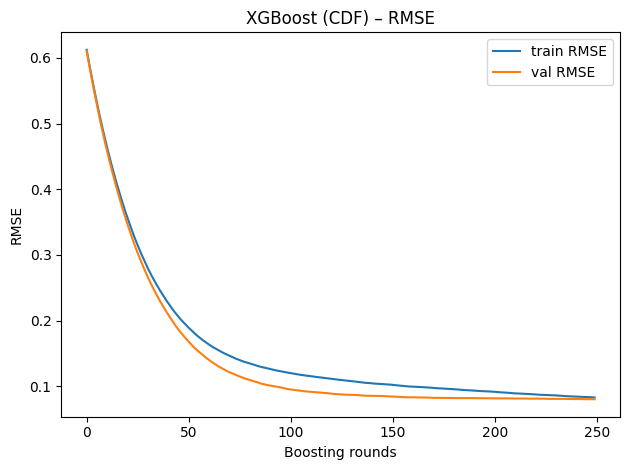

In [28]:
# CDF helper
def to_cdf_features(X):
    Xp = np.clip(X, 0, None)
    Xc = np.cumsum(Xp, axis=1)
    Xc = Xc / (Xc[:, -1, None] + 1e-12)
    return Xc

# Features
X_cdf = to_cdf_features(X)
Xtr, Xva, ytr, yva = train_test_split(X_cdf, y, test_size=0.2, random_state=0)

xgb = XGBRegressor(
    n_estimators=250,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="rmse",
    early_stopping_rounds=80,
    random_state=0,
    n_jobs=-1,
)

# Provide training + validation for tracked metrics
xgb.fit(Xtr, ytr, eval_set=[(Xtr, ytr), (Xva, yva)], verbose=False)

# Plot training/validation RMSE vs. boosting rounds
res = xgb.evals_result()
plt.figure()
plt.plot(res["validation_0"]["rmse"], label="train RMSE")
plt.plot(res["validation_1"]["rmse"], label="val RMSE")
plt.xlabel("Boosting rounds"); plt.ylabel("RMSE"); plt.title("XGBoost (CDF) – RMSE")
plt.legend(); plt.tight_layout()

# Validation metrics
yva_pred_xgb = xgb.predict(Xva)
rmse_xgb = mean_squared_error(yva, yva_pred_xgb)
mae_xgb = mean_absolute_error(yva, yva_pred_xgb)
print(f"CDF+XBG Val RMSE={rmse_xgb:.4f}, MAE={mae_xgb:.4f}, Best ntree={xgb.best_iteration}")


**Test on Exp data (CDF+XGB)**  

X_exp predictions (XGB): [3.2711892 3.7658918 3.7504845 3.2058496 3.7504845 3.7504845 3.7504845
 3.2513266 3.2693126 3.785077  3.8678892 3.4864082 3.772521  3.8896127
 3.7944539 3.2841647]


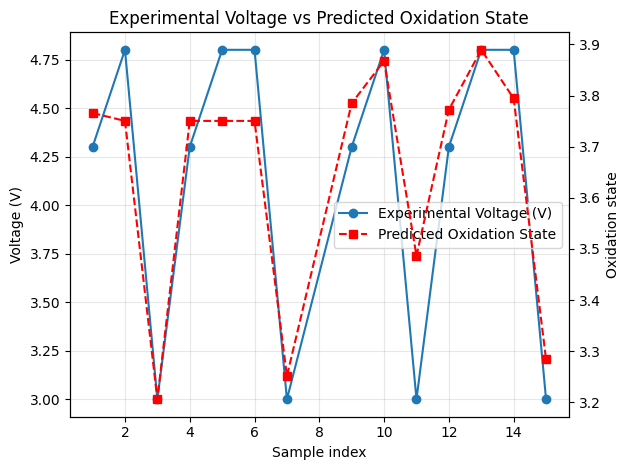

In [29]:
# Inference on experimental data
X_exp_cdf = to_cdf_features(X_exp)
y_exp_pred_xgb = xgb.predict(X_exp_cdf)
print("X_exp predictions (XGB):", y_exp_pred_xgb)

y_exp = np.asarray(y_exp)
y_pred = np.asarray(y_exp_pred_xgb, dtype=float)

# keep only samples where exp voltage is available
mask = y_exp != 'N/A'
x_idx = np.arange(len(y_exp))[mask]
v_exp = y_exp[mask].astype(float)       # experimental voltage (V)
ox_pred = y_pred[mask]                  # predicted oxidation state

fig, ax1 = plt.subplots()

# Left y-axis: experimental voltage
l1, = ax1.plot(x_idx, v_exp, marker='o', label='Experimental Voltage (V)')
ax1.set_xlabel('Sample index')
ax1.set_ylabel('Voltage (V)')
ax1.grid(True, alpha=0.3)

# Right y-axis: predicted oxidation state
ax2 = ax1.twinx()
l2, = ax2.plot(x_idx, ox_pred, marker='s', linestyle='--', label='Predicted Oxidation State', color='red')
ax2.set_ylabel('Oxidation state')

# Combined legend
lines = [l1, l2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

plt.title('Experimental Voltage vs Predicted Oxidation State')
plt.tight_layout()
plt.show()


#### **Example workflow 2: PCA with MLP**

**What it is**  
**PCA** compresses each normalized spectrum into a small set of orthogonal **principal components** (PCs) that capture most variance (edge/white-line/shoulder patterns). A lightweight **MLP** (multi-layer perceptron) then models the relationship between these low-dim features and the target (e.g., oxidation state, bond length).

**Why use in XAS (small dataset).**  
- **Sample-efficient**: reducing a 200–400-point spectrum to ~5–32 PCs slashes model degrees of freedom, improving generalization on limited data.  
- **Noise suppression**: PCA de-noises spectra by keeping dominant, physically meaningful modes and discarding high-frequency acquisition noise.  
- **Stable optimization**: tiny MLPs (1–2 hidden layers) train quickly and reliably on low-dim inputs; no need for complex architectures.  
- **Shift-tolerant (with care)**: after proper energy alignment, PCA absorbs residual baseline/shape variation, making the downstream MLP less sensitive.

**Practical notes.**  
- Fit **StandardScaler** and **PCA** on the **train fold only** (GroupKFold by compound/structure) and apply the frozen transforms to val/test/exp.  
- Choose `n_components` by **cumulative explained variance** (e.g., 95–99%) **and** downstream CV; start with 16 or 32 PCs.  
- Start with a **small MLP** (e.g., 64→32 hidden units, ReLU, dropout 0.1–0.3, weight decay 1e-5–1e-3); train 50–200 epochs with early stopping.  
- Keep an **unreduced baseline** (raw-spectrum tree model or 1D-CNN) to cross-check robustness; mixed-model ensembles often help.


Components to reach 95% variance: 4, 99% variance: 9


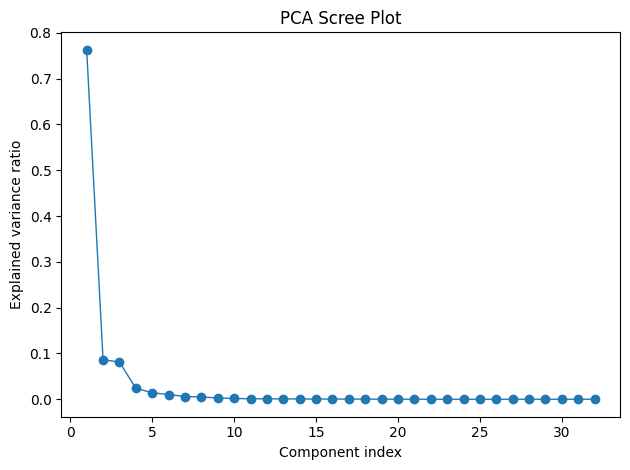

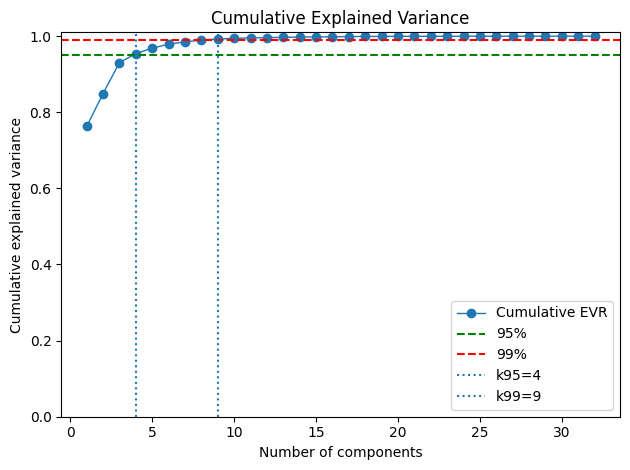

In [30]:
# Use PCA explained variance to pick n_components 

# Use only the TRAIN split to decide n_components (avoid leakage)
Xtr, Xva = train_test_split(X, test_size=0.2, random_state=0)

# Center features (no variance scaling) – standard for PCA
scaler = StandardScaler(with_mean=True, with_std=False)
Xtr_c = scaler.fit_transform(Xtr)

# Fit a PCA with many components to measure the curve
# For randomized SVD, n_components must be < min(n_samples, n_features)
kmax = 32
pca_probe = PCA(n_components=kmax, svd_solver="randomized", random_state=0)
pca_probe.fit(Xtr_c)

evr = pca_probe.explained_variance_ratio_                 # per-component
cev = np.cumsum(evr)                                      # cumulative

# Programmatic choice: first k reaching 95% / 99%
k95 = int(np.searchsorted(cev, 0.95) + 1)
k99 = int(np.searchsorted(cev, 0.99) + 1)
print(f"Components to reach 95% variance: {k95}, 99% variance: {k99}")

# --- Plots ---
# Scree plot (per-component)
plt.figure()
plt.plot(np.arange(1, kmax+1), evr, marker="o", linewidth=1)
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio")
plt.title("PCA Scree Plot")
plt.tight_layout()

# Cumulative explained variance with thresholds
plt.figure()
plt.plot(np.arange(1, kmax+1), cev, marker="o", linewidth=1, label="Cumulative EVR")
plt.axhline(0.95, linestyle="--", label="95%", color='green')
plt.axhline(0.99, linestyle="--", label="99%", color='red')
plt.axvline(k95, linestyle=":", label=f"k95={k95}")
plt.axvline(k99, linestyle=":", label=f"k99={k99}")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.ylim(0, 1.01)
plt.legend()
plt.title("Cumulative Explained Variance")
plt.tight_layout()

# --- Use the chosen k to refit PCA and transform train/val/test ---
k = k32 = 32  # or set k = k95 / k99 / your chosen elbow
pca = PCA(n_components=k, svd_solver="randomized", random_state=0)
Xtr_p = pca.fit_transform(Xtr_c)
Xva_p = pca.transform(scaler.transform(Xva))
# Later for test or experimental data X_exp:
# X_exp_p = pca.transform(scaler.transform(X_exp))


[MLP PCA] Best val MSE=0.020257 @ epoch 42


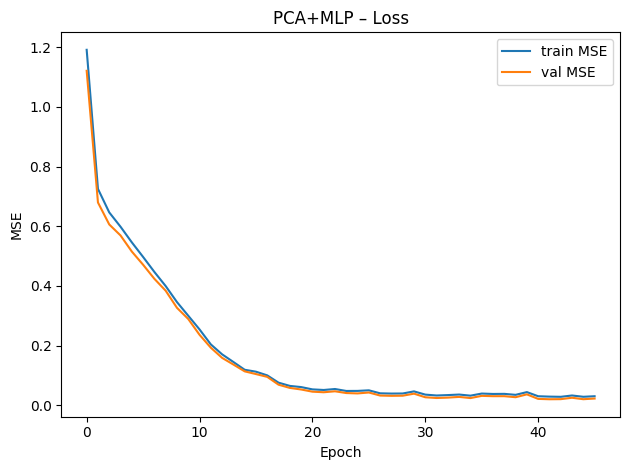

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess: center/scale then PCA to 32 components
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s, Xva_s = scaler.fit_transform(X), scaler.transform(X)  # fit on full X for demo
# If you want strict CV hygiene, fit scaler/PCA only on training fold like earlier.

pca = PCA(n_components=4, svd_solver="randomized", random_state=0)
X_pca = pca.fit_transform(Xtr_s)  # again, fit on full X for simplicity here
Xtr_p, Xva_p, ytr_p, yva_p = train_test_split(X_pca, y, test_size=0.2, random_state=0)

# Load datasets
def make_loaders(X_arr, y_arr, X_arr_val, y_arr_val, batch=64):
    X_t = torch.tensor(X_arr, dtype=torch.float32).unsqueeze(1)      # (N,1,L)
    y_t = torch.tensor(y_arr, dtype=torch.float32).unsqueeze(1)      # (N,1)
    Xv_t = torch.tensor(X_arr_val, dtype=torch.float32).unsqueeze(1)
    yv_t = torch.tensor(y_arr_val, dtype=torch.float32).unsqueeze(1)
    train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch, shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xv_t, yv_t), batch_size=max(128, batch), shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = make_loaders(Xtr_p, ytr_p, Xva_p, yva_p, batch=64)

# Simple MLP regressor
class MLPReg(nn.Module):
    def __init__(self, in_dim=4, hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2), nn.ReLU(),
            nn.Linear(hidden//2, 1)  # scalar regression
        )
    def forward(self, x):  # x: (B, 1, L) or (B, L)
        if x.ndim == 3:    # (B,1,L) -> (B,L)
            x = x.squeeze(1)
        return self.net(x)

# Simple 1D-CNN regressor
class XANESCNNReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.head = nn.Linear(64, 1)  # scalar regression

    def forward(self, x):
        z = self.net(x).squeeze(-1)   # (B,64)
        return self.head(z)            # (B,1)

model = MLPReg().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# Train with early stopping on val loss
hist = {"train_loss": [], "val_loss": []}
best = {"loss": np.inf, "state": None, "epoch": 0}
patience, patience_left = 15, 15
epochs = 100

for ep in range(1, epochs + 1):
    # train
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()

    # evaluate
    model.eval()
    with torch.no_grad():
        # training loss
        tr_losses, n_tr = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            l = loss_fn(model(xb), yb).item()
            tr_losses += l * yb.size(0); n_tr += yb.size(0)
        tr_loss = tr_losses / max(1, n_tr)

        # validation loss
        va_losses, n_va = 0.0, 0
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            l = loss_fn(model(xb), yb).item()
            va_losses += l * yb.size(0); n_va += yb.size(0)
        va_loss = va_losses / max(1, n_va)

    hist["train_loss"].append(tr_loss)
    hist["val_loss"].append(va_loss)

    if va_loss < best["loss"] - 1e-6:
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best.update({"loss": va_loss, "state": best_state, "epoch": ep})
    else:
        patience_left -= 1
        if patience_left == 0:
            break

# restore best
if best["state"] is not None:
    model.load_state_dict(best["state"])
print(f"[MLP PCA] Best val MSE={best['loss']:.6f} @ epoch {best['epoch']}")

# Plot loss curves (MSE)
plt.figure()
plt.plot(hist["train_loss"], label="train MSE")
plt.plot(hist["val_loss"], label="val MSE")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("PCA+MLP – Loss")
plt.legend(); plt.tight_layout()

X_exp predictions (PCA+MLP) [6.2649355 8.73899   8.831679  6.4026    8.725078  8.858667  8.8240385
 6.654887  6.360661  8.780438  8.673238  7.294122  8.897592  8.648546
 8.714529  6.0000696]


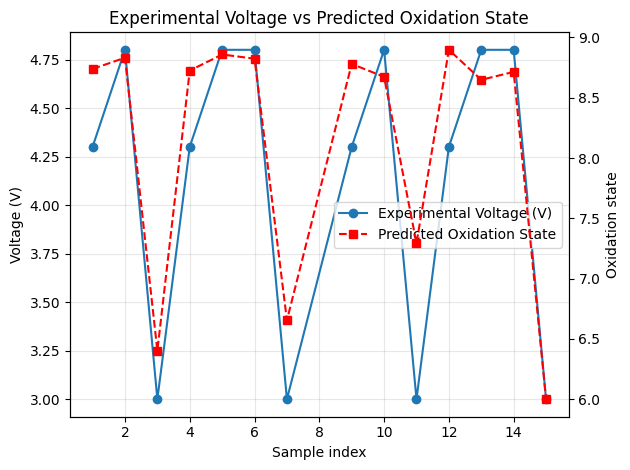

In [32]:
# Inference on experimental data for CNN
# IMPORTANT: apply the SAME scaler and PCA you fit above.
X_exp_s = scaler.transform(X_exp)
X_exp_pca = pca.transform(X_exp_s)
Xt = torch.tensor(X_exp_pca, dtype=torch.float32).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    y_exp_pred_cnn = model(Xt).squeeze(1).cpu().numpy()

print("X_exp predictions (PCA+MLP)", y_exp_pred_cnn)

y_exp = np.asarray(y_exp)
y_pred = np.asarray(y_exp_pred_cnn, dtype=float)

# keep only samples where exp voltage is available
mask = y_exp != 'N/A'
x_idx = np.arange(len(y_exp))[mask]
v_exp = y_exp[mask].astype(float)       # experimental voltage (V)
ox_pred = y_pred[mask]                  # predicted oxidation state

fig, ax1 = plt.subplots()

# Left y-axis: experimental voltage
l1, = ax1.plot(x_idx, v_exp, marker='o', label='Experimental Voltage (V)')
ax1.set_xlabel('Sample index')
ax1.set_ylabel('Voltage (V)')
ax1.grid(True, alpha=0.3)

# Right y-axis: predicted oxidation state
ax2 = ax1.twinx()
l2, = ax2.plot(x_idx, ox_pred, marker='s', linestyle='--', label='Predicted Oxidation State', color='red')
ax2.set_ylabel('Oxidation state')

# Combined legend
lines = [l1, l2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

plt.title('Experimental Voltage vs Predicted Oxidation State')
plt.tight_layout()
plt.show()

### MLP — Drawbacks on XAS

- **Information loss from linear compression.**  
  PCA keeps only the top variance directions; subtle, localized XANES cues (weak pre-edge features, narrow shoulders) can be pushed into low-variance PCs and discarded, hurting prediction.

- **Sensitivity to alignment and baselines.**  
  PCA requires consistent energy grids and careful normalization; small **δE shifts** or baseline drift change the PC scores, degrading MLP performance. Tree splits are largely scale/shift-invariant.

- **Global/orthogonal features ≠ local physics.**  
  PCs are global, orthogonal mixtures of the spectrum. XAS often hinges on **localized interactions** (e.g., a shoulder within a few eV). Tree models can isolate these with a few splits; PCs may blur them.

- **Small-N instability & tuning burden.**  
  With few samples, choosing `n_components`, weight decay, dropout, and early-stopping is fragile; results vary across seeds. Gradient training on tiny datasets tends to **overfit or underfit** unless carefully regularized.

- **Pipeline fragility and deployment overhead.**  
  Inference must replicate **StandardScaler → PCA → MLP** exactly. Any mismatch (grid, normalization, mode TEY/TFY) shifts PCs and can cause silent performance drops.

- **Weaker interpretability vs. trees.**  
  PCs and MLP weights are harder to map to physical energy regions. Tree models provide **feature importances/SHAP** and even **monotone constraints** (e.g., white-line centroid ↑ with oxidation), aiding physics sanity checks.

- **Poor handling of missing/irregular inputs.**  
  MLPs/PCA expect dense, fixed-length vectors without NaNs; tree ensembles tolerate missing values and uneven feature quality more gracefully.

- **Domain-gap brittleness (sim → exp).**  
  Linear compression can amplify minor distribution shifts between simulated and experimental spectra; tree models trained on robust features (e.g., CDF, peak descriptors) often transfer better.

> In practice, on many small XAS datasets, **tree-based models (e.g., XGBoost, random forest)** tend to achieve higher accuracy with less tuning and offer clearer diagnostics. PCA+MLP can still be useful when you need compact models or denoising, but it usually requires more careful preprocessing and validation.


### Hyperparameter Search: Grid vs Random vs Gaussian (Bayesian) — and How to Use Them

**Grid search**
- **What:** Evaluate every combination on a predefined grid (Cartesian product).
- **Pros:** Simple, reproducible; good for **very few** parameters/ranges.
- **Cons:** Scales exponentially; wastes trials on unimportant dims; coarse grids miss good values between ticks.

**Random search**
- **What:** Sample hyperparameters from distributions (uniform/log-uniform/etc.).
- **Pros:** Much better coverage than grid when only a few knobs matter; easy to parallelize; scales to higher dimensions.
- **Cons:** Still blind; may spend too many trials in mediocre regions; no principled exploration/exploitation tradeoff.

**Bayesian optimization**
- **What:** Fit a **Gaussian process** surrogate to map hyperparameters → score, with uncertainty. Pick the next point by maximizing an **acquisition** (e.g., Expected Improvement).
- **Pros:** **Sample-efficient** naturally balances exploration vs exploitation, handles noisy objectives (CV variance).
- **Cons:** Less friendly for many categorical parameters; GP scales poorly beyond a few hundred trials/dimensions; some overhead per iteration.

> **When to use GP-BO:** You have **small budgets** (e.g., <100 trials), **expensive evaluations** (K-fold CV), and a mix of continuous/discrete parameters with sensible bounds.

---

### Practical setup for XAS
- Use **grouped CV** (e.g., GroupKFold by compound/prototype) to prevent leakage.
- Define **log-uniform** priors for learning rates/regularization, **bounded integers** for depths/components.
- Stabilize with **multiple seeds** (average CV scores) if runs are noisy.
- Include **δE robustness** (optional): evaluate candidates with noise and shifts.

---

### Sample Gaussian-process BO (regression example, XGB on CDF)
```python

import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

# Features/targets prepared elsewhere:
# X_cdf: (n_samples, n_features), y: (n_samples,) numeric (e.g., oxidation state)
# groups: (n_samples,) group ids (e.g., composition); or set groups=None to ignore
cv = GroupKFold(n_splits=5) if 'groups' in globals() and groups is not None else None

space = [
    Integer(100, 1000,   name="n_estimators"),
    Real(1e-3, 0.3,      name="learning_rate", prior="log-uniform"),
    Integer(3, 10,       name="max_depth"),
    Real(0.5, 1.0,       name="subsample"),
    Real(0.5, 1.0,       name="colsample_bytree"),
    Real(1e-8, 10.0,     name="reg_lambda", prior="log-uniform"),
    Real(1e-8, 1.0,      name="reg_alpha",  prior="log-uniform"),
]

def cv_rmse(params):
    (n_estimators, learning_rate, max_depth, subsample,
     colsample_bytree, reg_lambda, reg_alpha) = params

    model = XGBRegressor(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        subsample=float(subsample),
        colsample_bytree=float(colsample_bytree),
        reg_lambda=float(reg_lambda),
        reg_alpha=float(reg_alpha),
        tree_method="hist",
        eval_metric="rmse",
        random_state=0,
        n_jobs=-1,
    )

    if cv is None:
        # Single split fallback
        n = X_cdf.shape[0]
        idx = np.random.RandomState(0).permutation(n)
        cut = int(0.8 * n)
        tr, va = idx[:cut], idx[cut:]
        model.fit(X_cdf[tr], y[tr], eval_set=[(X_cdf[va], y[va])], verbose=False,
                  early_stopping_rounds=50)
        pred = model.predict(X_cdf[va])
        return float(np.sqrt(mean_squared_error(y[va], pred)))

    rmses = []
    for tr, va in cv.split(X_cdf, y, groups if 'groups' in globals() else None):
        Xtr, Xva, ytr, yva = X_cdf[tr], X_cdf[va], y[tr], y[va]
        model.fit(Xtr, ytr, eval_set=[(Xva, yva)], verbose=False,
                  early_stopping_rounds=50)
        pred = model.predict(Xva)
        rmses.append(np.sqrt(mean_squared_error(yva, pred)))
    return float(np.mean(rmses))

res = gp_minimize(
    cv_rmse, space,
    n_calls=40, n_initial_points=10, acq_func="EI", random_state=0
)

print("Best CV RMSE:", res.fun)
print("Best params:", res.x)


### Sample grid search and random search
```python
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
from xgboost import XGBRegressor

model = XGBRegressor(tree_method="hist", eval_metric="rmse", random_state=0, n_jobs=-1)

param_grid = {
    "n_estimators": [400, 800, 1600, 3200],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.3, 0.1, 0.05],
}

grid = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error",
                    cv=cv if cv is not None else 5, n_jobs=-1)
grid.fit(X_cdf, y)
print("Grid best RMSE:", -grid.best_score_, "params:", grid.best_params_)

param_dist = {
    "n_estimators": (300, 4000),
    "max_depth": (3, 10),
    "learning_rate": loguniform(1e-3, 3e-1),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
}

rand = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=60,
                          scoring="neg_root_mean_squared_error",
                          cv=cv if cv is not None else 5, random_state=0, n_jobs=-1)
rand.fit(X_cdf, y)
print("Random best RMSE:", -rand.best_score_, "params:", rand.best_params_)
